# **Laboratorio 3 - Informe**

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

### **Objetivos**
El objetivo de este laboratorio es:
- Implementar funciones de AgenteRL para el ambiente open-ai gymnassium
- Analizar los resultados obtenidos luego de ejecuciones del agente entrenado
- Fundamentar la elección de los hiperparámetros utilizados

### **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import json


Defaulting to user installation because normal site-packages is not writeable


## **2. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [2]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 20

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins[1])

def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

## **3. Agentes y la interacción con el entorno**

Definimos una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Luego definimos la función `ejecutar_episodio` para ejecutar un episodio con el agente AgenteRL:

In [4]:
def ejecutar_episodio(agente, aprender, render, max_iteraciones=500):
    if (render):
        entorno = gym.make('LunarLander-v2', render_mode='human').env
    else: 
        entorno = gym.make('LunarLander-v2').env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        if render:
            entorno.render()
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # print(estado_siguiente)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio(recompensa_total)
    entorno.close()
    return recompensa_total

### **4. Programando un agente que aprende**

A continuación implementamos el agente:

In [5]:
class AgenteRL(Agente):
    # Pueden agregar parámetros al constructor
    def __init__(self, states, actions, gamma, initial_epsilon, final_epsilon, decay_factor) -> None:
        super().__init__()
        self.Q = np.zeros((states,actions))
        self.visits = np.zeros((states, actions))
        self.gamma = gamma
        self.epsilon = initial_epsilon
        self.final_epsilon = final_epsilon
        self.recompensa_maxima = -np.inf
        self.decay_factor = decay_factor
        self.threshold = 0
            
    def estado_discretizado_a_indice(self, estado_discretizado):
        return estado_discretizado[0] * 12800000 + estado_discretizado[1] * 640000 + estado_discretizado[2] * 32000 + \
           estado_discretizado[3] * 1600 + estado_discretizado[4] * 80 + estado_discretizado[5] * 4 + \
           estado_discretizado[6] * 2 + estado_discretizado[7]
           
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        estado_discretizado = discretize_state(estado, bins)
        row = self.estado_discretizado_a_indice(estado_discretizado)
        
        if explorar and np.random.random() < self.epsilon:
            return random.randrange(max_accion)  # Exploración
        else:
            return np.argmax(self.Q[row])  # Explotación
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        discretized_state_anterior = discretize_state(estado_anterior, bins)
        discretized_state_siguiente = discretize_state(estado_siguiente, bins)
        
        row_anterior = self.estado_discretizado_a_indice(discretized_state_anterior)
        self.visits[row_anterior, accion] += 1
        alpha_n = 1 / self.visits[row_anterior, accion]

        row_siguiente = self.estado_discretizado_a_indice(discretized_state_siguiente)
        
        # Fórmula de actualización de Q-learning
        if not terminado:
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa + self.gamma * np.max(self.Q[row_siguiente]))
        else:
            # Si el episodio terminó, no hay valor de futuro
            self.Q[row_anterior][accion] = (1 - alpha_n) * self.Q[row_anterior][accion] + alpha_n * (recompensa)

    def fin_episodio(self, recompensa_total):
        if recompensa_total > self.threshold: 
            self.epsilon = max(self.final_epsilon, self.epsilon*self.decay_factor)
            self.threshold += 1
        

#### **4.1 Diseño**

Nuestra implementación del agente sigue un flujo iterativo donde el agente aprende a maximizar su recompensa mediante la interacción continua con el entorno. Utilizamos una política epsilon-greedy para balancear entre la exploración de nuevas acciones y la explotación de las acciones que ya ha experimentado. El objetivo es aprender una función de valor $Q(s,a)$, que estima las recompensas esperadas para cada par de estado $s$ y acción $a$.

##### Parámetros
- **states**: Número total de estados posibles. Esto define la cantidad de filas de la matriz $Q$, que almacena los valores esperados de recompensa para cada combinación de estado y acción.
- **actions**: Número total de acciones posibles que el agente puede tomar en cada estado. Cada fila de la matriz $Q$ tiene una columna para cada acción.
- **gamma**: Factor de descuento ($\gamma$). Define la importancia de las recompensas futuras frente a las recompensas inmediatas. Un
$γ$ alto hace que el agente valore más las recompensas a largo plazo.
- **initial_epsilon**: Valor inicial de $\epsilon$, que controla la probabilidad inicial de que el agente explore (tome una acción aleatoria) en lugar de explotar (tomar la mejor acción según la matriz $Q$).
- **final_epsilon**: Valor mínimo que puede alcanzar $\epsilon$. Aunque $\epsilon$ disminuye durante el entrenamiento, nunca cae por debajo de este valor, garantizando que siempre haya un pequeño grado de exploración (si este valor es mayor a 0).
- **decay_factor**: Factor multiplicativo utilizado para reducir $\epsilon$ al final de cada episodio en función de las recompensas obtenidas. Un decaimiento controlado asegura una transición suave entre exploración y explotación.


#### Inicializacion
El constructor inicializa los parámetros y estructuras necesarias para que el agente aprenda en un entorno de aprendizaje por refuerzo.

- $Q$: Matriz de dimensiones $states \times actions$, inicializada en ceros, que almacena los valores $Q(s,a)$.
- **$visits$**: Matriz para contar el numero de veces que el agente ha visitado cada combinación de estado-acción.
- **$recompensa\_maxima$**: Variable para almacenar la mayor recompensa que obtuvo el agente a lo largo de los episodios ejecutados.

#### Estado discretizado a índice

Esta función convierte un estado discretizado en un índice único que se usa para acceder a la matriz $Q$. Dado que el entorno tiene un espacio de estados continuo o de alta dimensionalidad, esta función es esencial para almacenar los valores de $Q$ de manera eficiente.

La función recibe un estado discretizado representado como un vector de 8 componentes. Los primeros 6 componentes del vector pueden tomar 20 valores distintos (0 a 19), mientras que los últimos 2 pueden tomar solo 2 valores (0 y 1). Para transformar este vector en un índice único, se utiliza una fórmula que combina linealmente los componentes del estado con factores de escalamiento.

**Fórmula**:
$$\text{índice} = s_0 \times 12800000 + s_1 \times 640000 + s_2 \times 32000 + s_3 \times 1600 + s_4 \times 80 + s_5 \times 4 + s_6 \times 2 + s_7
$$

**Obs**: $12800000 = states / 20$, $640000 = 12800000 / 20$, ..., $2 = 4 / 2$, $1 = 2 / 2$

Esta técnica asegura que cada combinación única de valores de estado discretizado tenga un índice único

#### Elegir acción

Esta función implementa la política **epsilon_greedy** que balancea la exploración y explotación.

Recibe el estado actual del entorno, lo discretiza, y luego selecciona una acción aleatoria con probabilidad $\epsilon$ o la acción con el mayor valor de $Q(s,a)$ con probabilidad $1-\epsilon$.

#### Aprender
Esta función es responsable de actualizar los valores de $Q(s,a)$ después de cada paso en el entorno, utilizando la ecuación de Bellman.

Recibe el estado anterior y el siguiente estado, junto con la acción tomada, la recompensa recibida, y una bandera que indica si el episodio ha terminado y actualiza el valor de $Q(s,a)$ correspondiente al estado anterior y la acción tomada.

**Pasos**:
1. Discretiza los estados $s_t$ (estado_anterior) y $s_{t+1}$ (estado_siguiente).
2. Calcula la tasa de aprendizaje 
$$\alpha_n = 1/(visits(s_t, a_t))$$
3. Si el episodio no ha terminado, utiliza la fórmula de Q-learning:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha \left[ r_t + \gamma \max_a Q(s_{t+1}, a) \right]$$
4. Si el episodio ha terminado, la fórmula se reduce a:
$$Q(s_t, a_t) = (1 - \alpha) Q(s_t, a_t) + \alpha r_t$$

#### Fin Episodio

Esta función ajusta el valor de $\epsilon$ al final de cada episodio.

Recibe la recompensa total obtenida en el episodio. Si la recompensa supera la recompensa máxima registrada hasta el momento, se ajusta $\epsilon$ multiplicándolo por el $decay\_factor$. Esto favorece la explotación en los episodios posteriores si el agente ha sido exitoso.

**Pasos**:

1. Si la recompensa total es mayor que la recompensa máxima obtenida hasta ahora, actualiza la recompensa máxima y reduce $\epsilon$.
2. Asegura que $\epsilon$ nunca caiga por debajo de $final\_epsilon$.

Este ajuste dinámico de $\epsilon$ permite que el agente explore más al principio y, cuando mejora su rendimiento, reduzca la exploración para explotar lo aprendido.





### **5. Evaluación**

A continuación entrenaremos el agente con 100.000 episodios, para luego evaluar su desempeño con 1000 episodios de evaluación. Junto con el entrenamiento evaluaremos el decrecimiento del epsilon, la recompensa promedio cada 10.000 episodios, y la frecuencia de éxitos cada 10.000 episodios, con el fin de analizar la mejora del agente a lo largo del entrenamiento.

In [6]:
entorno = gym.make('LunarLander-v2').env
episodios = 100_000
agente = AgenteRL(np.prod(NUM_BINS),entorno.action_space.n,1,initial_epsilon=1,final_epsilon=0.1,decay_factor=0.9)

exitos = 0
recompensa_acumulada_intervalo = []
exitos_intervalo_array = []
exitos_intervalo = 0
recompensas = []
epsilons = []
intervalos = 1000

for i in range(episodios):
    recompensa = ejecutar_episodio(agente, aprender=True, render=False)
    if (recompensa >= 200):
        exitos += 1
        exitos_intervalo += 1
    recompensa_acumulada_intervalo += [recompensa]
    if (i % intervalos == 0):
        print('Episodio', i,'- Promedio de últimas', intervalos ,'iteraciones: ', np.mean(recompensa_acumulada_intervalo),'- Epsilon:', agente.epsilon, '- Threshold:', agente.threshold)
        recompensas.append(np.mean(recompensa_acumulada_intervalo))
        epsilons.append(agente.epsilon)
        exitos_intervalo_array.append(exitos_intervalo)
        exitos_intervalo = 0
        recompensa_acumulada_intervalo = []

Episodio 0 - Promedio de últimas 1000 iteraciones:  -350.3809130202644 - Epsilon: 1 - Threshold: 0
Episodio 1000 - Promedio de últimas 1000 iteraciones:  -162.1970749248288 - Epsilon: 0.10941898913151243 - Threshold: 21
Episodio 2000 - Promedio de últimas 1000 iteraciones:  -140.16464023707522 - Epsilon: 0.1 - Threshold: 46
Episodio 3000 - Promedio de últimas 1000 iteraciones:  -128.57994636005037 - Epsilon: 0.1 - Threshold: 57
Episodio 4000 - Promedio de últimas 1000 iteraciones:  -127.55312860382121 - Epsilon: 0.1 - Threshold: 65
Episodio 5000 - Promedio de últimas 1000 iteraciones:  -121.62281827882282 - Epsilon: 0.1 - Threshold: 76
Episodio 6000 - Promedio de últimas 1000 iteraciones:  -116.01976357760871 - Epsilon: 0.1 - Threshold: 92
Episodio 7000 - Promedio de últimas 1000 iteraciones:  -114.4443803733085 - Epsilon: 0.1 - Threshold: 109
Episodio 8000 - Promedio de últimas 1000 iteraciones:  -109.06560824376342 - Epsilon: 0.1 - Threshold: 130
Episodio 9000 - Promedio de últimas 1

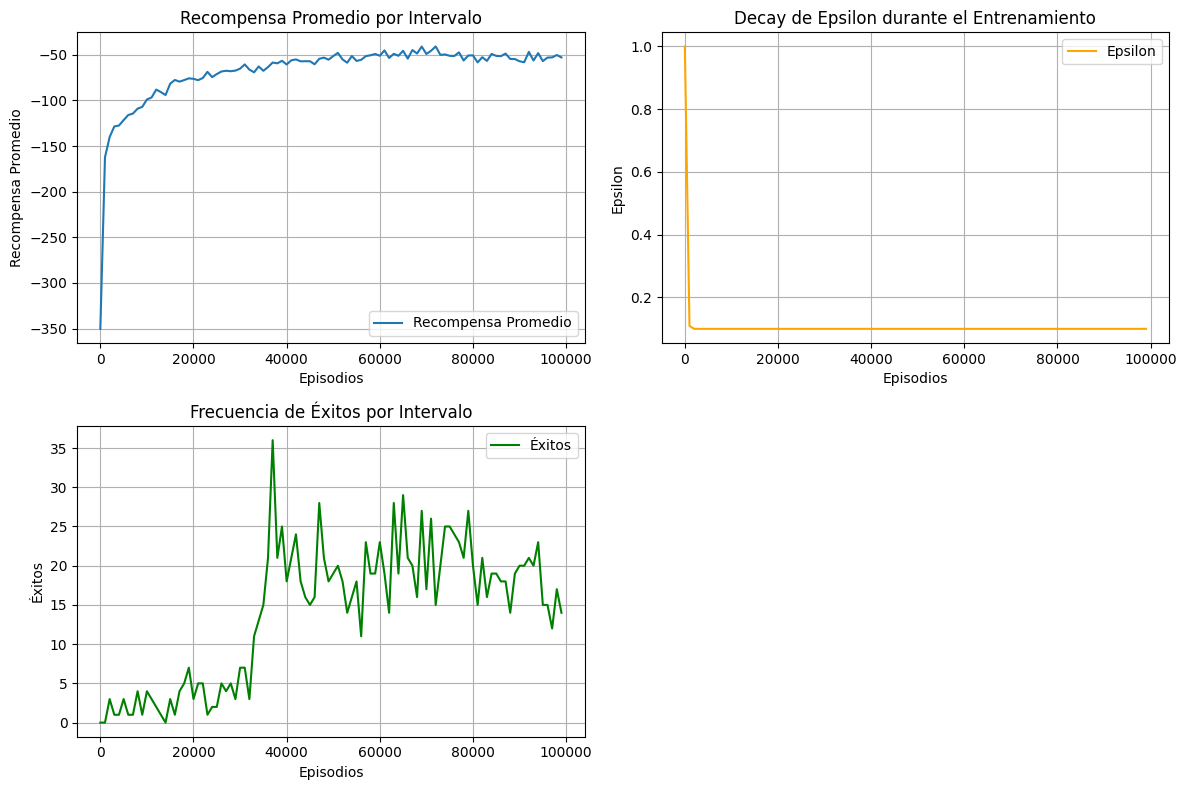

In [7]:

episodios_plot = range(0, episodios, intervalos)

# Crear la figura y los ejes
plt.figure(figsize=(12, 8))  # Cambiar el tamaño para acomodar mejor las tres gráficas

# Primera gráfica: Recompensas en función de episodios
plt.subplot(2, 2, 1)
plt.plot(episodios_plot, recompensas, label='Recompensa Promedio')
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Intervalo')
plt.grid(True)
plt.legend()

# Segunda gráfica: Epsilon en función de episodios
plt.subplot(2, 2, 2)
plt.plot(episodios_plot, epsilons, label='Epsilon', color='orange')
plt.xlabel('Episodios')
plt.ylabel('Epsilon')
plt.title('Decay de Epsilon durante el Entrenamiento')
plt.grid(True)
plt.legend()

# Tercera gráfica: Éxitos en función de episodios
plt.subplot(2, 2, 3)
plt.plot(episodios_plot, exitos_intervalo_array, label='Éxitos', color='green')
plt.xlabel('Episodios')
plt.ylabel('Éxitos')
plt.title('Frecuencia de Éxitos por Intervalo')
plt.grid(True)
plt.legend()

# Ajustar automáticamente los espacios entre subplots
plt.tight_layout()

# Mostrar las gráficas
plt.show()


A través del gráfico de recompensas promedio cada 1000 episodios, observamos que inicialmente el agente recibe recompensas negativas bajas, lo que indica un desempeño deficiente en el aterrizaje (choques o aterrizajes ineficientes). Sin embargo, a medida que avanza el entrenamiento, el agente mejora gradualmente su desempeño, alcanzando un promedio de recompensa cercano a -50. Esto sugiere que el agente está aprendiendo a aterrizar de manera más segura y controlada con el tiempo. Sin embargo, la recompensa promedio sigue siendo negativa, por lo que no estamos teniendo una tasa de éxito ideal.

Luego, en el gráfico de decaimiento del epsilon, como era de esperarse, al ser el factor de decaimiento `decay_factor = 0.9`, el espilon disminuye al mínimo en las primeras 1000 iteraciones, dando mayor énfasis a la explotación sobre la exploración para el resto de episodios. Aún así, con el valor mínimo de epsilon establecido, por cada iteración se mantendrá un 10% de probabilidad de exploración, permitiendo que esto aún ocurra a lo largo del entrenamiento.

Por último, es observable que existe una tendencia a la mejora en la frecuencia de éxitos del agente, indicando que efectivamente está aprendiendo y obteniendo aterrizajes exitosos

Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
    * Definir los estados (filas) de la matriz Q que cumplan con las condiciones planteadas (caida libre sin rotación, hovering, quieto en el piso)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

In [36]:
#ejecutar_episodio(agente, aprender=False, render=True, max_iteraciones=500)
#print()
exitos = 0
num_episodios = 1000
recompensa_episodios = []
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente, aprender=False, render=False)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
        print('it', i, ' Exito: ',recompensa)
    recompensa_episodios += [recompensa]
    
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


it 0  Exito:  278.0187071783041
it 38  Exito:  263.28048451611653
it 148  Exito:  225.51075904319032
it 166  Exito:  232.47249397872386
it 217  Exito:  222.3937913166448
it 226  Exito:  225.6591865997608
it 228  Exito:  221.63550401837233
it 241  Exito:  212.8329642967629
it 279  Exito:  220.0551927118088
it 304  Exito:  274.93935014535543
it 324  Exito:  248.7690794755532
it 339  Exito:  239.66450191149167
it 382  Exito:  254.18234544225922
it 383  Exito:  205.57261908888927
it 389  Exito:  269.77585615104584
it 431  Exito:  245.36542113973852
it 508  Exito:  259.0020912841592
it 522  Exito:  256.864060796067
it 536  Exito:  257.14139321652647
it 542  Exito:  227.02457255071658
it 638  Exito:  221.67887189646402
it 667  Exito:  260.0765341353126
it 776  Exito:  255.441872709731
it 806  Exito:  255.83304553461574
it 817  Exito:  271.2076653971443
it 842  Exito:  286.41032198286973
it 974  Exito:  227.03272475952326
Tasa de éxito: 0.027. Se obtuvo -55.66706771410268 de recompensa, en pr

#### **5.1 Cortes de matriz Q**

La función `state_examples` tiene como objetivo realizar un corte en la matriz Q, extrayendo subconjuntos de valores correspondientes a diferentes combinaciones de estados discretizados que representan situaciones específicas en el entorno del agente. Este corte permite analizar cómo se comporta el agente en esos estados particulares y cómo varían los valores Q para cada acción disponible, o sea, cómo el agente evalúa las acciones en función de la situación en la que se encuentra.

La función recibe varios parámetros que definen los rangos de las características del estado del agente, tales como:

- **min_x**, **max_x**, **min_y**, **max_y**: Definen los rangos de la posición en el espacio (coordenadas X e Y).
- **delta_x_vel**, **delta_y_vel**: Controlan el rango de velocidad horizontal y vertical.
- **delta_theta_izq**, **delta_theta_der**, **delta_theta_vel_izq**, **delta_theta_vel_der**: Definen el rango de los ángulos de rotación y velocidad angular, descompuestos en sentido.
- **pie_izq_en_contacto**, **pie_der_en_contacto**: Indican si los pies izquierdo o derecho del agente están en contacto con el suelo.

Dada la división en 20 bins de cada dimensión, cada parámetro tendrá como valor posible un número entero entre 0 y 19. Para los parámetros describiendo coordenadas X e Y por ejemplo, observamos que el agente suele tomar como posición inicial **x=9 o x=10** e **y=11**. 

Dentro de la función, se generan múltiples combinaciones de estos parámetros, que se utilizan para obtener el índice correspondiente en la matriz Q. Estos índices se calculan con la función `agente.estado_discretizado_a_indice`, detallada previamente en el informe.

In [30]:
def state_examples(min_x, max_x, min_y, max_y, delta_x_vel, delta_y_vel, delta_theta_izq, delta_theta_der, delta_theta_vel_izq, delta_theta_vel_der, pie_izq_en_contacto, pie_der_en_contacto):
    Rows = []
    for x in range(min_x,max_x):
        for y in range(min_y,max_y):
            for x_vel in range(9-delta_x_vel,11+delta_x_vel):
                for y_vel in range(9-delta_y_vel,11+delta_y_vel):
                    for theta in range(9-delta_theta_der,11+delta_theta_izq):
                        for theta_vel in range(9-delta_theta_vel_der,11+delta_theta_vel_izq):
                            index = (int) (agente.estado_discretizado_a_indice([x,y,x_vel,y_vel,theta,theta_vel,pie_izq_en_contacto,pie_der_en_contacto]))
                            Rows = np.append(Rows, index)
    mRows = np.zeros(((int) (len(Rows)),4))
    for i in range(len(Rows)):
        mRows[i] = agente.Q[(int) (Rows[i])]
    mRows = mRows[np.any(mRows != 0, axis=1)]
    return mRows

Luego, con esta función definida, se realizan varios cortes en la matriz Q que, mediante variaciones de los parámetros previamente descritos, describen posibles situaciones en las que podría estar nuestro agente. Luego, obtenemos el promedio de recompensas asociadas a acciones, para poder analizar qué acción tomaría el agente en estas situaciones recopiladas.

In [38]:

# En el piso
print('En el piso')
floor = state_examples(min_x=0, max_x=20, min_y=0, max_y=9, delta_x_vel=1, delta_y_vel=0, delta_theta_izq=0, delta_theta_der=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=1, pie_der_en_contacto=1)
print(len(floor))
print(np.mean(floor,0))

# Cayendo
print('Cayendo')
falling = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=3, delta_theta_izq=0, delta_theta_der=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling))
print(np.mean(falling, 0))

# Hovering
print('Hovering')
hovering = state_examples(min_x=8, max_x=12, min_y=7, max_y=12, delta_x_vel=1, delta_y_vel=1, delta_theta_izq=0, delta_theta_der=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(hovering))
print(np.mean(hovering, 0))

# Aterrizando suavemente
print('Aterrizando suavemente')
landing_soft = state_examples(min_x=8, max_x=12, min_y=0, max_y=4, delta_x_vel=0, delta_y_vel=0, delta_theta_izq=0, delta_theta_der=0, delta_theta_vel_izq=0, delta_theta_vel_der=0, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(landing_soft))
print(np.mean(landing_soft, 0))

# Girando hacia la izquierda en el aire
print('Girando hacia la izquierda en el aire')
falling_spinning = state_examples(min_x=4, max_x=16, min_y=4, max_y=12, delta_x_vel=1, delta_y_vel=2, delta_theta_izq=5, delta_theta_der=-2, delta_theta_vel_izq=5, delta_theta_vel_der=-2, pie_izq_en_contacto=0, pie_der_en_contacto=0)
print(len(falling_spinning))
print(np.mean(falling_spinning, 0))



En el piso
598
[-7.67874006 -5.4855052  -5.60805611 -4.02071994]
Cayendo
876
[6.54883408 6.11443226 7.82653238 6.12750318]
Hovering
778
[6.9953692  6.72525288 8.33412566 6.68858218]
Aterrizando suavemente
243
[12.45004258 11.96925871 12.48665587 12.48289429]
Girando hacia la izquierda en el aire
1806
[-8.53846445 -8.31701743 -7.45367418 -6.229351  ]
